In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# Step 1: Install the necessary libraries
!pip install datasets diffusers transformers torch torchvision tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 42.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 158.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


Conditional Diffusion Model for Reconstructing Dark Matter Density Fields from Observed Stellar Density Field

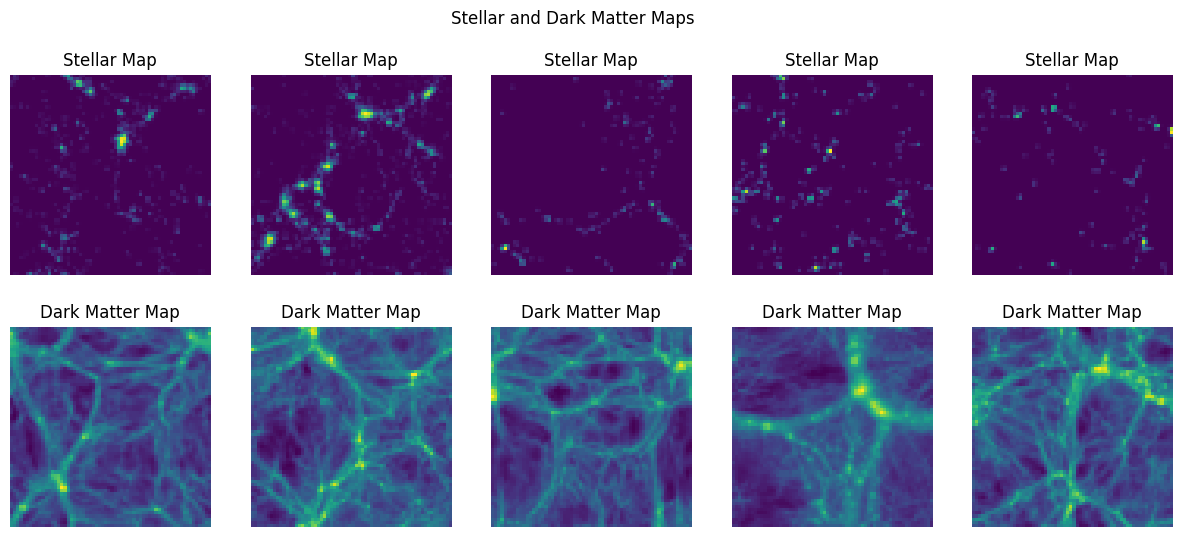

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

# Configuration settings
config = {
    "batch_size": 16,
    "epochs": 1,
    "learning_rate": 1e-4,
    "num_timesteps": 1000,
    "image_size": 64,
    "conditioning_channels": 1,
    "target_channels": 1,
    "stellar_file": '/groups/mlprojects/dm_diffusion/data/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy',
    "dm_file": '/groups/mlprojects/dm_diffusion/data/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy'
}

# Custom Dataset class to load .npy files with memory mapping
class SlicedDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.data = np.load(file_path, mmap_mode='r')  # Memory map to save memory
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.log10(x + 1e-8)),  # Log transformation
    transforms.Resize((config["image_size"], config["image_size"])),  # Resize to 64x64
    transforms.Lambda(lambda x: ((x - x.min()) / (x.max() - x.min()) - 0.5) * 2)  # Normalize to [-1, 1]
])

# Initialize datasets using memory-mapped SlicedDataset
stellar_dataset = SlicedDataset(file_path=config["stellar_file"], transform=transform)
dm_dataset = SlicedDataset(file_path=config["dm_file"], transform=transform)

# DataLoader for batching
stellar_dataloader = DataLoader(stellar_dataset, batch_size=config["batch_size"], shuffle=True)
dm_dataloader = DataLoader(dm_dataset, batch_size=config["batch_size"], shuffle=True)

# Initialize the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=config["num_timesteps"])

# Function to visualize the maps
def visualize_maps(stellar_loader, dm_loader, num_samples=5):
    stellar_maps = next(iter(stellar_loader))
    dm_maps = next(iter(dm_loader))

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        axes[0, i].imshow(stellar_maps[i].squeeze().cpu(), cmap="viridis")
        axes[0, i].axis("off")
        axes[0, i].set_title("Stellar Map")

        axes[1, i].imshow(dm_maps[i].squeeze().cpu(), cmap="viridis")
        axes[1, i].axis("off")
        axes[1, i].set_title("Dark Matter Map")

    plt.suptitle("Stellar and Dark Matter Maps")
    plt.show()

# Visualize samples from the datasets
visualize_maps(stellar_dataloader, dm_dataloader, num_samples=5)


/home/ajchandr/miniconda3/envs/dm_diff/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1/1, Average Loss: 0.059231


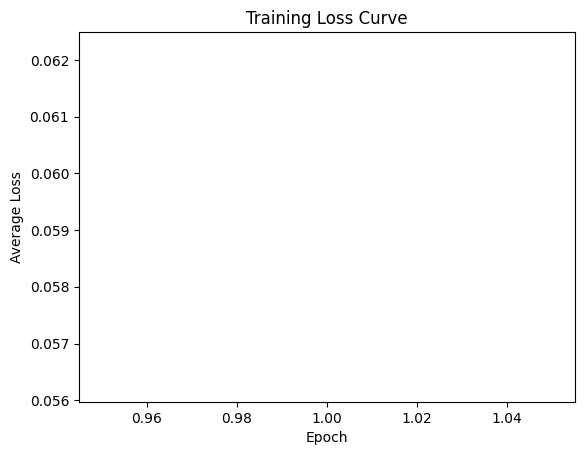

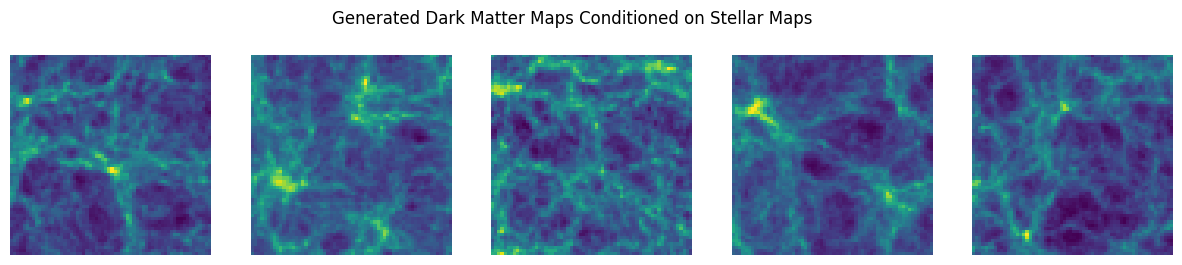

In [5]:
import matplotlib.pyplot as plt

# Conditional U-Net model for diffusion
class ConditionalUNet(nn.Module):
    def __init__(self, conditioning_channels=1, target_channels=1):
        super(ConditionalUNet, self).__init__()
        self.unet = UNet2DModel(
            sample_size=config["image_size"],
            in_channels=conditioning_channels + target_channels,
            out_channels=target_channels,
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
            block_out_channels=(48, 96, 192, 384),
            layers_per_block=2,
            norm_num_groups=8,
            act_fn="silu",
            attention_head_dim=8,
            add_attention=True,
            downsample_type='resnet',
            upsample_type='resnet'
        )

    def forward(self, x, t, condition):
        condition = condition.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, condition), dim=1)
        return self.unet(x, t).sample

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

epoch_losses = []
for epoch in range(config["epochs"]):
    total_loss = 0.0
    num_batches = 0

    for stellar_maps, dm_maps in zip(stellar_dataloader, dm_dataloader):
        stellar_maps, dm_maps = stellar_maps.to(device), dm_maps.to(device)

        noise = torch.randn_like(dm_maps)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (dm_maps.shape[0],), device=device).long()

        noisy_dm = noise_scheduler.add_noise(dm_maps, noise, timesteps)

        pred_noise = model(noisy_dm, timesteps, stellar_maps)

        loss = nn.MSELoss()(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Calculate and store the average loss for this epoch
    avg_epoch_loss = total_loss / num_batches
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{config['epochs']}, Average Loss: {avg_epoch_loss:.6f}")

plt.plot(range(1, config["epochs"] + 1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.show()

def generate_dm_maps(model, stellar_maps, scheduler):
    model.eval()
    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)
        for t in reversed(range(scheduler.num_train_timesteps)):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = scheduler.step(residual, t, x).prev_sample
    return x

sample_stellar_maps = next(iter(stellar_dataloader)).to(device)
generated_dm_maps = generate_dm_maps(model, sample_stellar_maps, noise_scheduler)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(generated_dm_maps[i].squeeze().cpu(), cmap="viridis")
    ax.axis("off")
plt.suptitle("Generated Dark Matter Maps Conditioned on Stellar Maps")
plt.show()


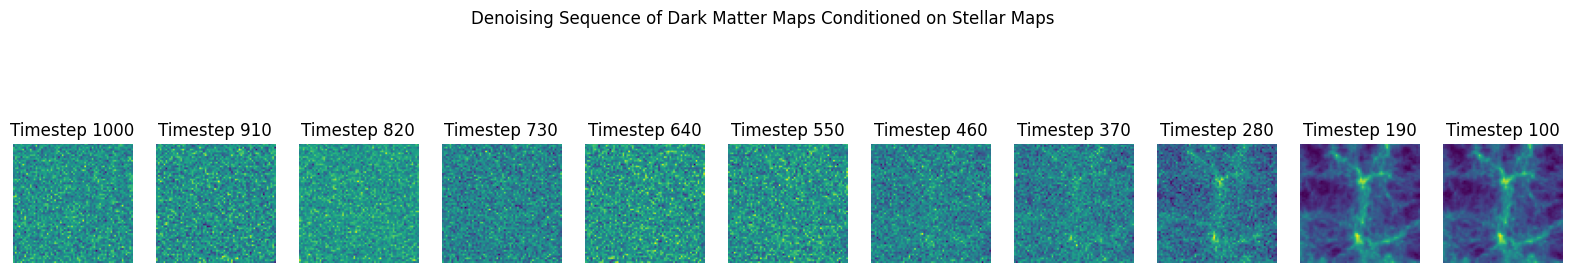

In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Sampling loop - Generate DM maps conditioned on stellar maps with visualization of each timestep
def generate_dm_maps_with_sequence(model, stellar_maps, noise_scheduler, num_timesteps=10):
    model.eval()
    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)

        denoising_sequence = []

        for t in reversed(range(noise_scheduler.num_train_timesteps)):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = noise_scheduler.step(residual, t, x).prev_sample

            if t % (noise_scheduler.num_train_timesteps // num_timesteps) == 0:
                denoising_sequence.append(x.clone().cpu())

        denoising_sequence.append(x.clone().cpu())

    return denoising_sequence

sample_stellar_maps = next(iter(stellar_dataloader)).to(device)
denoising_sequence = generate_dm_maps_with_sequence(model, sample_stellar_maps, noise_scheduler, num_timesteps=10)

fig, axes = plt.subplots(1, len(denoising_sequence), figsize=(20, 4))

for i, ax in enumerate(axes):
    ax.imshow(denoising_sequence[i][0].squeeze(), cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Timestep {noise_scheduler.num_train_timesteps - i * (noise_scheduler.num_train_timesteps // len(denoising_sequence))}")

plt.suptitle("Denoising Sequence of Dark Matter Maps Conditioned on Stellar Maps")
plt.show()

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

# Function to calculate cross-correlation for 10 samples at 10 timesteps
def calculate_cross_correlation(stellar_maps, dm_maps, model, noise_scheduler):
    cross_corr_results = []

    # Select 10 evenly spaced timesteps from the diffusion process
    timesteps = torch.linspace(0, noise_scheduler.num_train_timesteps - 1, 10).long().to(device)

    # Iterate through 10 samples of stellar and dark matter maps
    for i in range(10):
        sample_cross_corr = []
        stellar_map = stellar_maps[i].unsqueeze(0).to(device)  # Shape: (1, 1, H, W)
        dm_map = dm_maps[i].unsqueeze(0).to(device)  # Shape: (1, 1, H, W)

        # Generate noisy versions of the dark matter map at each selected timestep
        for t in timesteps:
            noise = torch.randn_like(dm_map)
            noisy_dm_map = noise_scheduler.add_noise(dm_map, noise, t)

            # Calculate cross-correlation between stellar map and noisy dark matter map
            corr = correlate2d(stellar_map.squeeze().cpu().numpy(), noisy_dm_map.squeeze().cpu().numpy(), mode="same")
            sample_cross_corr.append(corr)

        cross_corr_results.append(sample_cross_corr)  # List of 10 timesteps for each sample

    return cross_corr_results, timesteps.cpu().numpy()

# Visualization of cross-correlation across 10 timesteps for 10 samples
def visualize_cross_corr_timesteps(cross_corr_results, timesteps):
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))

    for i in range(10):  # 10 samples
        for j in range(10):  # 10 timesteps
            ax = axes[i, j]
            ax.imshow(cross_corr_results[i][j], cmap="viridis")
            ax.axis("off")
            if i == 0:
                ax.set_title(f"Timestep {timesteps[j]}")
            if j == 0:
                ax.set_ylabel(f"Sample {i+1}")

    plt.suptitle("Cross-Correlation of Stellar Map and Noisy Conditional Samples Across Timesteps")
    plt.tight_layout()
    plt.show()

# Generate and visualize cross-correlation between stellar maps and noisy conditional samples across timesteps
# Get 10 samples from the DataLoader
stellar_maps = next(iter(stellar_dataloader)).to(device)[:10]
dm_maps = next(iter(dm_dataloader)).to(device)[:10]

# Calculate cross-correlation for 10 samples at 10 timesteps
cross_corr_results, timesteps = calculate_cross_correlation(stellar_maps, dm_maps, model, noise_scheduler)

# Visualize the cross-correlation for 10 samples over 10 timesteps
visualize_cross_corr_timesteps(cross_corr_results, timesteps)


ModuleNotFoundError: No module named 'scipy'

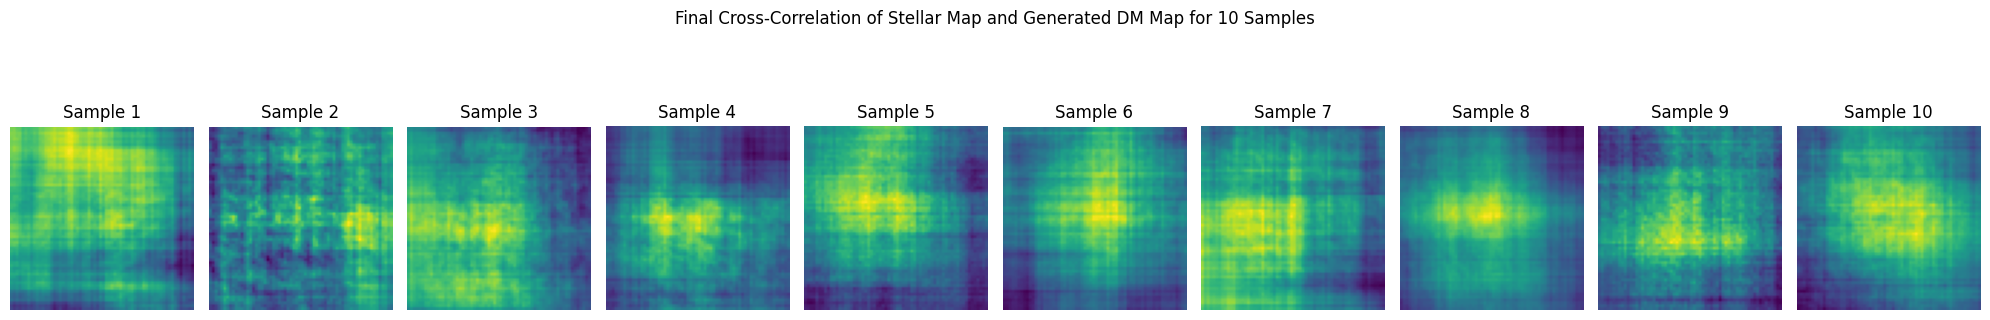

In [ ]:
import matplotlib.pyplot as plt
import torch
from scipy.signal import correlate2d

# Sampling loop with cross-correlation calculation for final timestep
def calculate_cross_corr_sequence(model, stellar_maps, noise_scheduler):
    model.eval()
    cross_corr_sequence = []

    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)

        for t in range(noise_scheduler.num_train_timesteps):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = noise_scheduler.step(residual, t, x).prev_sample

            # Collect cross-correlation only for the final timestep
            if t == noise_scheduler.num_train_timesteps - 1:
                cross_corr_batch = []
                for i in range(10):  # Calculate for 10 samples
                    stellar_map = stellar_maps[i].squeeze().cpu().numpy()
                    final_map = x[i].squeeze().cpu().numpy()
                    corr = correlate2d(stellar_map, final_map, mode="same")
                    cross_corr_batch.append(corr)

                cross_corr_sequence.extend(cross_corr_batch)

    return cross_corr_sequence

# Run the cross-correlation sequence generation for the final timestep
sample_stellar_maps = next(iter(stellar_dataloader)).to(device)[:10]  # Use 10 samples from stellar map
cross_corr_sequence = calculate_cross_corr_sequence(model, sample_stellar_maps, noise_scheduler)

# Visualization of cross-correlation for 10 samples at the final timestep
fig, axes = plt.subplots(1, len(cross_corr_sequence), figsize=(20, 4))

# `axes` is now a 1D array, so we can iterate over it with a single index
for i, ax in enumerate(axes):
    ax.imshow(cross_corr_sequence[i], cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Sample {i + 1}")

plt.suptitle("Final Cross-Correlation of Stellar Map and Generated DM Map for 10 Samples")
plt.tight_layout()
plt.show()


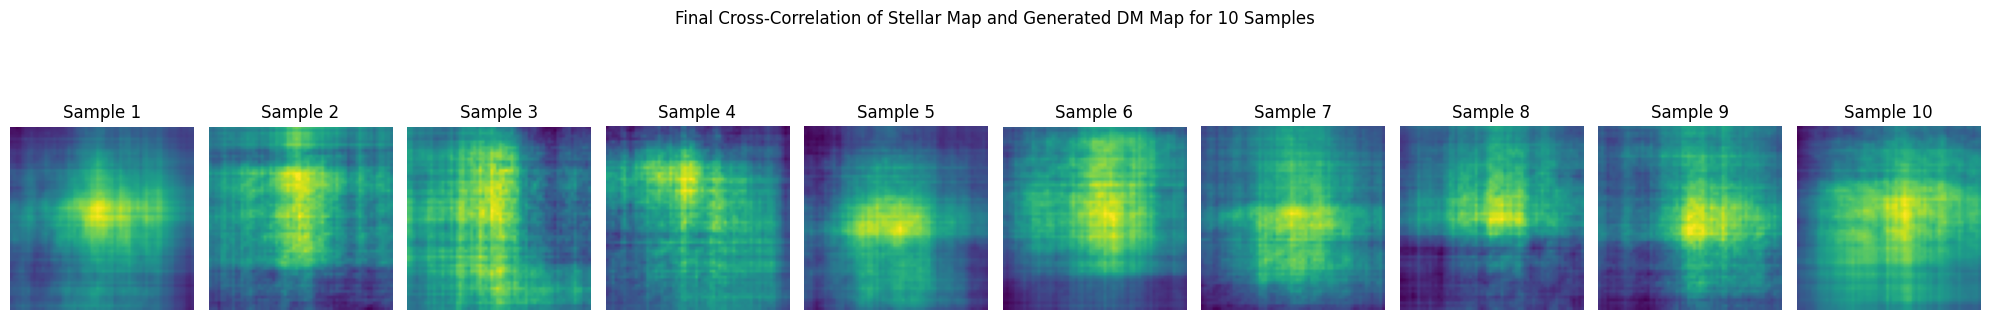

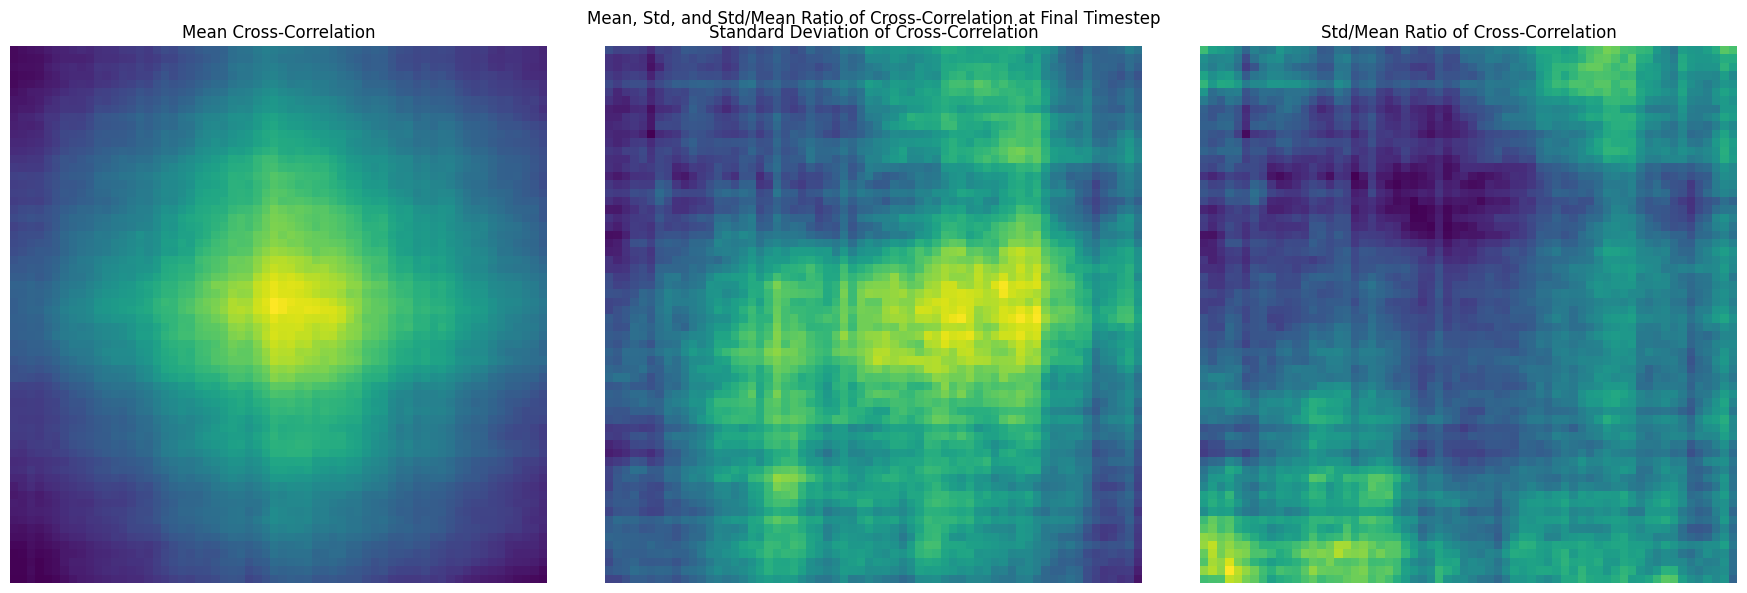

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.signal import correlate2d

# Sampling loop with cross-correlation calculation for the final timestep
def calculate_cross_corr_sequence(model, stellar_maps, noise_scheduler):
    model.eval()
    cross_corr_sequence = []

    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)

        for t in range(noise_scheduler.num_train_timesteps):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = noise_scheduler.step(residual, t, x).prev_sample

            # Collect cross-correlation only for the final timestep
            if t == noise_scheduler.num_train_timesteps - 1:
                cross_corr_batch = []
                for i in range(10):  # Calculate for 10 samples
                    stellar_map = stellar_maps[i].squeeze().cpu().numpy()
                    final_map = x[i].squeeze().cpu().numpy()
                    corr = correlate2d(stellar_map, final_map, mode="same")
                    cross_corr_batch.append(corr)

                cross_corr_sequence.extend(cross_corr_batch)

    return np.array(cross_corr_sequence)  # Convert to numpy array for further calculations

# Run the cross-correlation sequence generation for the final timestep
sample_stellar_maps = next(iter(stellar_dataloader)).to(device)[:10]  # Use 10 samples from stellar map
cross_corr_sequence = calculate_cross_corr_sequence(model, sample_stellar_maps, noise_scheduler)

# Calculate Mean, Standard Deviation, and Std/Mean Ratio
mean_corr = cross_corr_sequence.mean(axis=0)  # Mean across samples
std_corr = cross_corr_sequence.std(axis=0)    # Standard deviation across samples
ratio_std_mean = np.divide(std_corr, mean_corr, where=mean_corr != 0)  # Avoid division by zero

# Visualization of cross-correlation for 10 samples at the final timestep
fig, axes = plt.subplots(1, len(cross_corr_sequence), figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(cross_corr_sequence[i], cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Sample {i + 1}")

plt.suptitle("Final Cross-Correlation of Stellar Map and Generated DM Map for 10 Samples")
plt.tight_layout()
plt.show()

# Visualization of Mean, Std, and Std/Mean Ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mean Cross-Correlation
axes[0].imshow(mean_corr, cmap="viridis")
axes[0].set_title("Mean Cross-Correlation")
axes[0].axis("off")

# Standard Deviation of Cross-Correlation
axes[1].imshow(std_corr, cmap="viridis")
axes[1].set_title("Standard Deviation of Cross-Correlation")
axes[1].axis("off")

# Std/Mean Ratio of Cross-Correlation
axes[2].imshow(ratio_std_mean, cmap="viridis")
axes[2].set_title("Std/Mean Ratio of Cross-Correlation")
axes[2].axis("off")

plt.suptitle("Mean, Std, and Std/Mean Ratio of Cross-Correlation at Final Timestep")
plt.tight_layout()
plt.show()


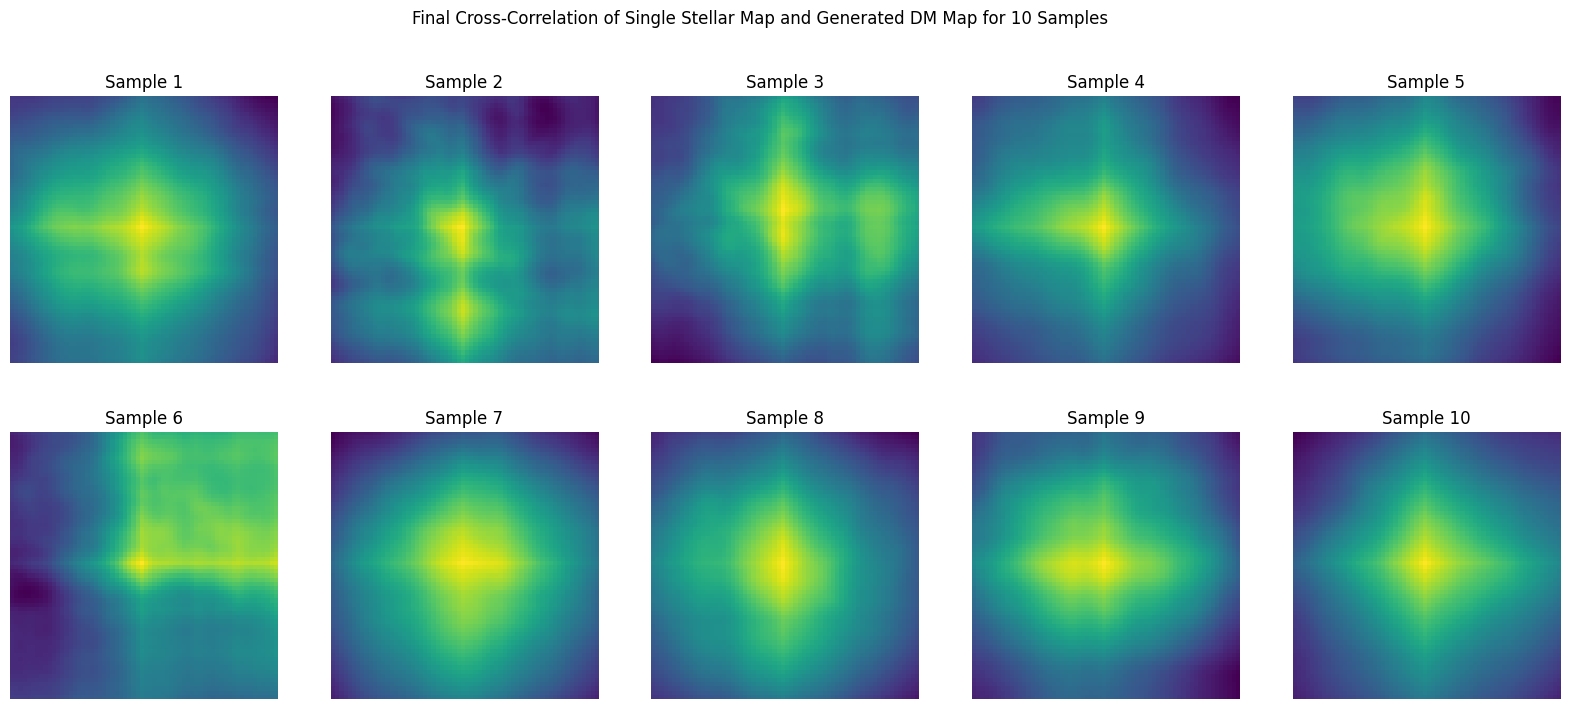

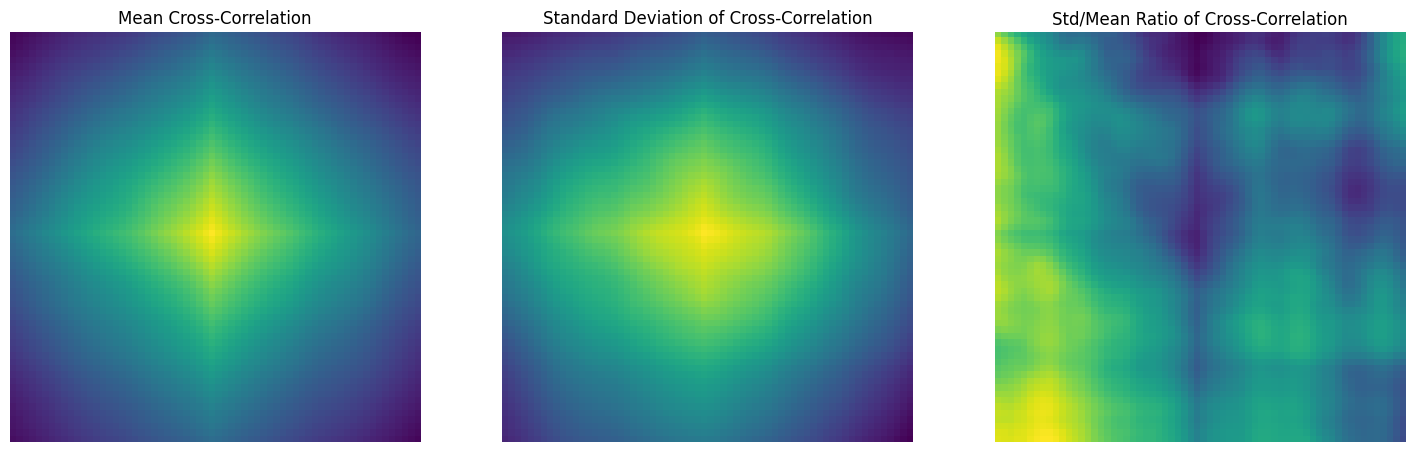

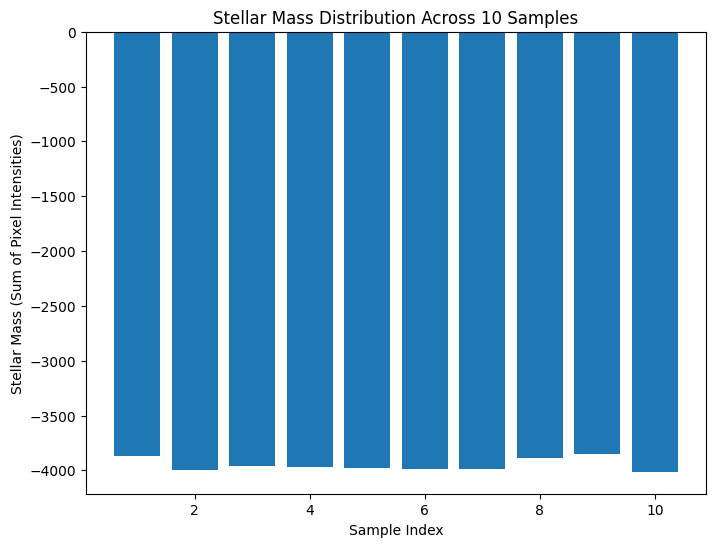

<ipython-input-26-6feb4a59cdbf>:101: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


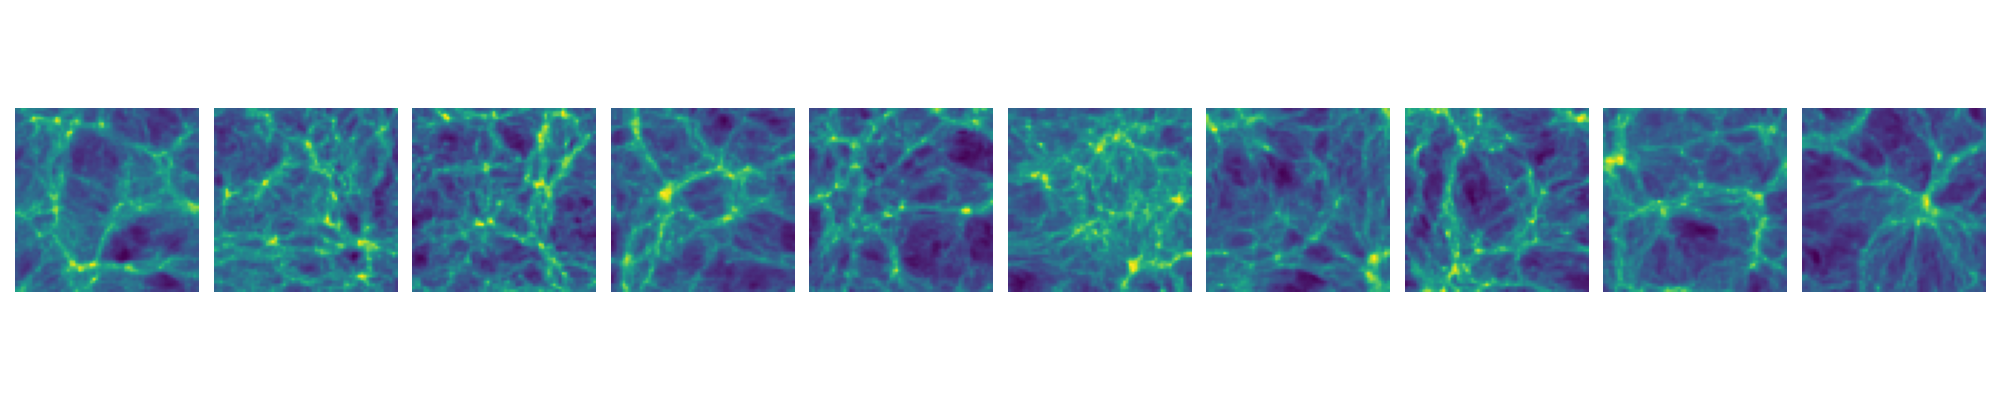

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import imageio
from IPython.display import Image, display

# Function to calculate cross-correlation for only the final timestep during the sampling loop
def calculate_final_cross_correlation(stellar_maps, model, noise_scheduler):
    cross_corr_results = []
    final_generated_maps = []

    with torch.no_grad():
        num_samples = stellar_maps.size(0)
        x = torch.randn((num_samples, 1, config["image_size"], config["image_size"])).to(device)

        # Select a single stellar map (e.g., the first one) as the reference for all samples
        reference_stellar_map = stellar_maps[0].squeeze().cpu().numpy()

        # Iterate over the timesteps in reverse
        for t in reversed(range(noise_scheduler.num_train_timesteps)):
            timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)
            residual = model(x, timesteps, stellar_maps)
            x = noise_scheduler.step(residual, t, x).prev_sample

            # Check if it's the final timestep to collect cross-correlation results
            if t == 0:  # Only the final timestep
                for i in range(num_samples):  # Calculate for each generated map
                    final_map = x[i].squeeze().cpu().numpy()  # Final generated dark matter map
                    corr = correlate2d(reference_stellar_map, final_map, mode="same")
                    cross_corr_results.append(corr)
                final_generated_maps = x.clone().cpu()  # Store the final generated maps

    return np.array(cross_corr_results), final_generated_maps  # Cross-corr: (samples, H, W)

# Calculate Mean, Standard Deviation, and Std/Mean for Final Cross-Correlation
def calculate_mean_std_ratio(cross_corr_results):
    mean_corr = cross_corr_results.mean(axis=0)  # Mean across samples
    std_corr = cross_corr_results.std(axis=0)    # Standard deviation across samples
    ratio_std_mean = np.divide(std_corr, mean_corr, where=mean_corr != 0)  # Avoid division by zero
    return mean_corr, std_corr, ratio_std_mean

# Stellar Mass Calculation
def calculate_stellar_mass(stellar_maps):
    return [torch.sum(stellar_map).item() for stellar_map in stellar_maps]

# Visualization Functions

# 1. Display Final Cross-Correlation Results for 10 Samples
def display_final_cross_corr_samples(cross_corr_results):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(cross_corr_results[i], cmap="viridis")
        ax.axis("off")
        ax.set_title(f"Sample {i+1}")
    plt.suptitle("Final Cross-Correlation of Single Stellar Map and Generated DM Map for 10 Samples")
    plt.show()

# 2. Plot Mean, Std, and Std/Mean Ratio for Final Cross-Correlation
def plot_mean_std_ratio(mean_corr, std_corr, ratio_std_mean):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Mean
    axes[0].imshow(mean_corr, cmap="viridis")
    axes[0].set_title("Mean Cross-Correlation")
    axes[0].axis("off")

    # Standard Deviation
    axes[1].imshow(std_corr, cmap="viridis")
    axes[1].set_title("Standard Deviation of Cross-Correlation")
    axes[1].axis("off")

    # Std/Mean Ratio
    axes[2].imshow(ratio_std_mean, cmap="viridis")
    axes[2].set_title("Std/Mean Ratio of Cross-Correlation")
    axes[2].axis("off")

    plt.show()

# 3. Plot Stellar Mass for Each Sample
def plot_stellar_mass(stellar_mass):
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, 11), stellar_mass)
    plt.xlabel("Sample Index")
    plt.ylabel("Stellar Mass (Sum of Pixel Intensities)")
    plt.title("Stellar Mass Distribution Across 10 Samples")
    plt.show()

# 4. Create GIF of Final Generated DM Maps
def create_final_maps_gif(final_generated_maps, filename="final_maps_sequence.gif"):
    images = []
    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(final_generated_maps[i].squeeze().cpu().numpy(), cmap="viridis")
        ax.axis("off")
    plt.tight_layout()

    # Convert figure to an image array
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
    plt.close(fig)

    imageio.mimsave(filename, images, fps=1)
    display(Image(filename=filename))

# Execute Calculations and Visualizations
# Get 10 samples from DataLoader
stellar_maps = next(iter(stellar_dataloader)).to(device)[:10]

# Calculate final cross-correlation results for the last timestep
final_cross_corr_results, final_generated_maps = calculate_final_cross_correlation(stellar_maps, model, noise_scheduler)

# Display visualizations
display_final_cross_corr_samples(final_cross_corr_results)

# Optional: Calculate and plot mean, std, and std/mean ratio
mean_corr, std_corr, ratio_std_mean = calculate_mean_std_ratio(final_cross_corr_results)
plot_mean_std_ratio(mean_corr, std_corr, ratio_std_mean)

# Optional: Calculate and plot stellar mass distribution
stellar_mass = calculate_stellar_mass(stellar_maps)
plot_stellar_mass(stellar_mass)

# Optional: Create GIF showing the final generated DM maps for 10 samples
create_final_maps_gif(final_generated_maps)
